# Coursework for Cardiac MR Image Segmentation (2021-2022)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device  :',device)

device  : cuda


In [3]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

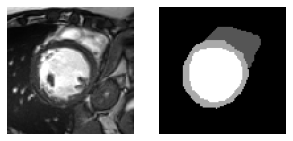

(96, 96)


In [4]:

import os
import cv2 #import OpenCV

data_dir = '/content/drive/MyDrive/data/train/'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)
print(image.shape)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [5]:

import torch
import torch.utils.data as data
import cv2
import os
from glob import glob
path = '/content/drive/MyDrive/data/train'


class TrainDataset(data.Dataset):
    def __init__(self, root=path):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        #print(self.img_files)
        self.mask_files = []
        #print(self.img_files)
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()    #tensor vlaues for data( image) and label( mask) is returned.

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels, mid_channels = None):
    if not mid_channels:
            mid_channels = out_channels
    return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()

        self.dconv_pre = double_conv(1,3)       
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
       # self.dconv_down5 = double_conv(512, 1024)       

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        convpre = self.dconv_pre(x) #not maxpooling here
        conv1 = self.dconv_down1(convpre)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

class CNNSEG(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 3)
        self.dconv_down2 = double_conv(3, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)          

        self.maxpool = nn.MaxPool2d(2) #kernel size two..stride = none

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        
       # self.dconv_up3 = double_conv(256 + 512, 256)
        #self.dconv_up2 = double_conv(128 + 256, 128)
        #self.dconv_up1 = double_conv(128 + 64, 64)
        self.dconv_up4 = double_conv(512+512, 512)
        self.dconv_up3 = double_conv()
        self.dconv_up2 = double_conv(512+512, 512)
        self.dconv_up1 = double_conv(512+512, 512)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 

        conv5 = self.dconv_down5(x)

        x = self.upsample(conv5)        #left with 512 channels and ..becomes 12 * 12
        x = torch.cat([x, conv4], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


#https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

model = UNet() # We can now create a model using your defined segmentation model

In [7]:



model = model.to(device)

model

UNet(
  (dconv_pre): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

In [8]:
from torchsummary import  summary
#help to view the visualisation of the model

summary(model,input_size=(1,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 96, 96]              30
       BatchNorm2d-2            [-1, 3, 96, 96]               6
              ReLU-3            [-1, 3, 96, 96]               0
            Conv2d-4            [-1, 3, 96, 96]              84
       BatchNorm2d-5            [-1, 3, 96, 96]               6
              ReLU-6            [-1, 3, 96, 96]               0
            Conv2d-7           [-1, 64, 96, 96]           1,792
       BatchNorm2d-8           [-1, 64, 96, 96]             128
              ReLU-9           [-1, 64, 96, 96]               0
           Conv2d-10           [-1, 64, 96, 96]          36,928
      BatchNorm2d-11           [-1, 64, 96, 96]             128
             ReLU-12           [-1, 64, 96, 96]               0
        MaxPool2d-13           [-1, 64, 48, 48]               0
           Conv2d-14          [-1, 128,

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [ ]:

import torch.optim as optim
from torch.optim import lr_scheduler

"""
def dice_loss(pred,target, smooth = 1.):

    pred = pred.contiguous()
    target = target.contiguous()    
    
    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.

    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().

    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


criterion = nn.CrossEntropyLoss()

# so we have two types of loss the dice loss and cross entropy loss

def optimizer():
  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)

optimizer_ft = optimizer()
def exp_lr_scheduler():
  return lr_scheduler.StepLR(optimizer_ft,step_size=30,gamma=0.1)
"""


"\ndef dice_loss(pred,target, smooth = 1.):\n\n    pred = pred.contiguous()\n    target = target.contiguous()    \n    \n    #When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.\n\n    #Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().\n\n    \n\n    intersection = (pred * target).sum(dim=2).sum(dim=2)\n    \n    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))\n    \n    return loss.mean()\n\n\ncriterion = nn.CrossEntropyLoss()\n\n# so we have two types of loss the dice loss and cross entropy loss\n\ndef optimizer():\n  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)\n\noptimiz

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [9]:
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py

import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


Epoch 1/10: 3img [00:00, 11.62img/s, loss (batch)=0.0782]

train loss 0.12673169374465942  step : 1  epoch : 0
train loss 0.8881195187568665  step : 2  epoch : 0
train loss 0.07815337181091309  step : 3  epoch : 0


Epoch 1/10: 7img [00:00, 13.04img/s, loss (batch)=0.144]

train loss 0.8405141830444336  step : 4  epoch : 0
train loss 0.2169458568096161  step : 5  epoch : 0
train loss 0.1438361257314682  step : 6  epoch : 0


Epoch 1/10: 10img [00:00, 13.52img/s, loss (batch)=0.271]

train loss 0.2208821028470993  step : 7  epoch : 0
train loss 0.26546362042427063  step : 8  epoch : 0
train loss 0.4985002875328064  step : 9  epoch : 0
train loss 0.27141833305358887  step : 10  epoch : 0


Epoch 1/10: 14img [00:01, 14.53img/s, loss (batch)=0.293]

train loss 0.24554289877414703  step : 11  epoch : 0
train loss 0.6451693773269653  step : 12  epoch : 0
train loss 0.47285714745521545  step : 13  epoch : 0
train loss 0.29291239380836487  step : 14  epoch : 0


Epoch 1/10: 18img [00:01, 15.39img/s, loss (batch)=0.308]

train loss 0.3451603353023529  step : 15  epoch : 0
train loss 0.2973984181880951  step : 16  epoch : 0
train loss 0.2884810268878937  step : 17  epoch : 0
train loss 0.30835649371147156  step : 18  epoch : 0


Epoch 1/10: 22img [00:01, 16.26img/s, loss (batch)=0.273]

train loss 0.3069022595882416  step : 19  epoch : 0
train loss 0.22338996827602386  step : 20  epoch : 0
train loss 0.2823115587234497  step : 21  epoch : 0
train loss 0.2729001045227051  step : 22  epoch : 0


Epoch 1/10: 26img [00:01, 15.96img/s, loss (batch)=0.186]

train loss 0.28037214279174805  step : 23  epoch : 0
train loss 0.2450781911611557  step : 24  epoch : 0
train loss 0.20234572887420654  step : 25  epoch : 0
train loss 0.18566212058067322  step : 26  epoch : 0


Epoch 1/10: 30img [00:02, 16.16img/s, loss (batch)=0.248]

train loss 0.34068843722343445  step : 27  epoch : 0
train loss 0.30346620082855225  step : 28  epoch : 0
train loss 0.2166237235069275  step : 29  epoch : 0
train loss 0.24808518588542938  step : 30  epoch : 0


Epoch 1/10: 34img [00:02, 16.36img/s, loss (batch)=0.656]

train loss 0.36079704761505127  step : 31  epoch : 0
train loss 0.23065270483493805  step : 32  epoch : 0
train loss 0.33410337567329407  step : 33  epoch : 0
train loss 0.6561653017997742  step : 34  epoch : 0


Epoch 1/10: 38img [00:02, 16.98img/s, loss (batch)=0.185]

train loss 0.20286798477172852  step : 35  epoch : 0
train loss 0.23692363500595093  step : 36  epoch : 0
train loss 0.30438289046287537  step : 37  epoch : 0
train loss 0.1851949393749237  step : 38  epoch : 0


Epoch 1/10: 42img [00:02, 16.70img/s, loss (batch)=0.232]

train loss 0.2640235424041748  step : 39  epoch : 0
train loss 0.2845594584941864  step : 40  epoch : 0
train loss 0.327176034450531  step : 41  epoch : 0
train loss 0.23171371221542358  step : 42  epoch : 0


Epoch 1/10: 46img [00:02, 16.74img/s, loss (batch)=0.215]

train loss 0.3164941668510437  step : 43  epoch : 0
train loss 0.19331224262714386  step : 44  epoch : 0
train loss 0.19712887704372406  step : 45  epoch : 0
train loss 0.2153162658214569  step : 46  epoch : 0


Epoch 1/10: 50img [00:03, 17.10img/s, loss (batch)=0.179]

train loss 0.2630319595336914  step : 47  epoch : 0
train loss 0.2980661392211914  step : 48  epoch : 0
train loss 0.2678970396518707  step : 49  epoch : 0
train loss 0.17873390018939972  step : 50  epoch : 0


Epoch 1/10: 54img [00:03, 17.13img/s, loss (batch)=0.184]

train loss 0.18309728801250458  step : 51  epoch : 0
train loss 0.13358767330646515  step : 52  epoch : 0
train loss 0.326768696308136  step : 53  epoch : 0
train loss 0.18368802964687347  step : 54  epoch : 0


Epoch 1/10: 58img [00:03, 17.25img/s, loss (batch)=0.194]

train loss 0.14644643664360046  step : 55  epoch : 0
train loss 0.21997883915901184  step : 56  epoch : 0
train loss 0.32257068157196045  step : 57  epoch : 0
train loss 0.19367621839046478  step : 58  epoch : 0


Epoch 1/10: 62img [00:03, 17.16img/s, loss (batch)=0.191]

train loss 0.7814715504646301  step : 59  epoch : 0
train loss 0.27363818883895874  step : 60  epoch : 0
train loss 0.18489165604114532  step : 61  epoch : 0
train loss 0.190778449177742  step : 62  epoch : 0


Epoch 1/10: 66img [00:04, 17.03img/s, loss (batch)=0.127]

train loss 0.1907062530517578  step : 63  epoch : 0
train loss 0.1564592719078064  step : 64  epoch : 0
train loss 0.1364263892173767  step : 65  epoch : 0
train loss 0.1274246722459793  step : 66  epoch : 0


Epoch 1/10: 70img [00:04, 17.25img/s, loss (batch)=0.157]

train loss 0.1718088984489441  step : 67  epoch : 0
train loss 0.2602190375328064  step : 68  epoch : 0
train loss 0.1417781263589859  step : 69  epoch : 0
train loss 0.15684710443019867  step : 70  epoch : 0


Epoch 1/10: 74img [00:04, 17.24img/s, loss (batch)=0.174]

train loss 0.46777990460395813  step : 71  epoch : 0
train loss 0.15127985179424286  step : 72  epoch : 0
train loss 0.15262025594711304  step : 73  epoch : 0
train loss 0.17356763780117035  step : 74  epoch : 0


Epoch 1/10: 78img [00:04, 17.37img/s, loss (batch)=0.152]

train loss 0.23954735696315765  step : 75  epoch : 0
train loss 0.20218737423419952  step : 76  epoch : 0
train loss 0.22632639110088348  step : 77  epoch : 0
train loss 0.15230406820774078  step : 78  epoch : 0


Epoch 1/10: 82img [00:05, 17.03img/s, loss (batch)=0.133]

train loss 0.16796019673347473  step : 79  epoch : 0
train loss 0.11657532304525375  step : 80  epoch : 0
train loss 0.34207621216773987  step : 81  epoch : 0
train loss 0.1331123411655426  step : 82  epoch : 0


Epoch 1/10: 86img [00:05, 16.92img/s, loss (batch)=0.16] 

train loss 0.19899068772792816  step : 83  epoch : 0
train loss 0.341183066368103  step : 84  epoch : 0
train loss 0.2241387963294983  step : 85  epoch : 0
train loss 0.16015802323818207  step : 86  epoch : 0


Epoch 1/10: 91img [00:05, 17.55img/s, loss (batch)=0.181]

train loss 0.11655654013156891  step : 87  epoch : 0
train loss 0.22955001890659332  step : 88  epoch : 0
train loss 0.17314738035202026  step : 89  epoch : 0
train loss 0.18131618201732635  step : 90  epoch : 0


Epoch 1/10: 94img [00:05, 17.39img/s, loss (batch)=0.198]

train loss 0.41964831948280334  step : 91  epoch : 0
train loss 0.20105856657028198  step : 92  epoch : 0
train loss 0.14013372361660004  step : 93  epoch : 0
train loss 0.19847124814987183  step : 94  epoch : 0


Epoch 1/10: 98img [00:06, 17.41img/s, loss (batch)=0.126]

train loss 0.2713054418563843  step : 95  epoch : 0
train loss 0.2909991443157196  step : 96  epoch : 0
train loss 0.22131596505641937  step : 97  epoch : 0
train loss 0.12603849172592163  step : 98  epoch : 0


Epoch 1/10: 100img [00:06, 16.21img/s, loss (batch)=0.216]


train loss 0.1233774945139885  step : 99  epoch : 0
train loss 0.21557092666625977  step : 100  epoch : 0


Epoch 2/10: 4img [00:00, 14.09img/s, loss (batch)=0.105]

train loss 0.16463011503219604  step : 101  epoch : 1
train loss 0.3178209662437439  step : 102  epoch : 1
train loss 0.2577039897441864  step : 103  epoch : 1
train loss 0.10456962138414383  step : 104  epoch : 1


Epoch 2/10: 9img [00:00, 17.50img/s, loss (batch)=0.136]

train loss 0.1973050981760025  step : 105  epoch : 1
train loss 0.11993402987718582  step : 106  epoch : 1
train loss 0.18354034423828125  step : 107  epoch : 1
train loss 0.1363115906715393  step : 108  epoch : 1


Epoch 2/10: 13img [00:00, 17.94img/s, loss (batch)=0.0964]

train loss 0.18281784653663635  step : 109  epoch : 1
train loss 0.18077926337718964  step : 110  epoch : 1
train loss 0.2028171420097351  step : 111  epoch : 1
train loss 0.09637551754713058  step : 112  epoch : 1


Epoch 2/10: 17img [00:00, 17.82img/s, loss (batch)=0.106]

train loss 0.11910101026296616  step : 113  epoch : 1
train loss 0.09224510937929153  step : 114  epoch : 1
train loss 0.2116980254650116  step : 115  epoch : 1
train loss 0.10615415126085281  step : 116  epoch : 1


Epoch 2/10: 20img [00:01, 17.73img/s, loss (batch)=0.225]

train loss 0.18345099687576294  step : 117  epoch : 1
train loss 0.19240237772464752  step : 118  epoch : 1
train loss 0.23173530399799347  step : 119  epoch : 1
train loss 0.22514905035495758  step : 120  epoch : 1


Epoch 2/10: 24img [00:01, 17.25img/s, loss (batch)=0.137]

train loss 0.12140554934740067  step : 121  epoch : 1
train loss 0.0665910542011261  step : 122  epoch : 1
train loss 0.2181902527809143  step : 123  epoch : 1
train loss 0.13684095442295074  step : 124  epoch : 1


Epoch 2/10: 28img [00:01, 17.17img/s, loss (batch)=0.138]

train loss 0.1228468120098114  step : 125  epoch : 1
train loss 0.17328059673309326  step : 126  epoch : 1
train loss 0.30837199091911316  step : 127  epoch : 1
train loss 0.1379663348197937  step : 128  epoch : 1


Epoch 2/10: 32img [00:01, 17.19img/s, loss (batch)=0.11] 

train loss 0.30978646874427795  step : 129  epoch : 1
train loss 0.22859947383403778  step : 130  epoch : 1
train loss 0.20371830463409424  step : 131  epoch : 1
train loss 0.10995268076658249  step : 132  epoch : 1


Epoch 2/10: 36img [00:02, 17.00img/s, loss (batch)=0.441]

train loss 0.14463262259960175  step : 133  epoch : 1
train loss 0.19026213884353638  step : 134  epoch : 1
train loss 0.1207776740193367  step : 135  epoch : 1
train loss 0.44065719842910767  step : 136  epoch : 1


Epoch 2/10: 40img [00:02, 16.70img/s, loss (batch)=0.128]

train loss 0.15809467434883118  step : 137  epoch : 1
train loss 0.3260761499404907  step : 138  epoch : 1
train loss 0.29870161414146423  step : 139  epoch : 1
train loss 0.12804293632507324  step : 140  epoch : 1


Epoch 2/10: 44img [00:02, 17.12img/s, loss (batch)=0.244]

train loss 0.2805253863334656  step : 141  epoch : 1
train loss 0.11447286605834961  step : 142  epoch : 1
train loss 0.22057181596755981  step : 143  epoch : 1
train loss 0.24355734884738922  step : 144  epoch : 1


Epoch 2/10: 48img [00:02, 16.74img/s, loss (batch)=0.311]

train loss 0.34119871258735657  step : 145  epoch : 1
train loss 0.16160352528095245  step : 146  epoch : 1
train loss 0.14248670637607574  step : 147  epoch : 1
train loss 0.31059372425079346  step : 148  epoch : 1


Epoch 2/10: 53img [00:03, 17.38img/s, loss (batch)=0.165]

train loss 0.17875173687934875  step : 149  epoch : 1
train loss 0.1594265103340149  step : 150  epoch : 1
train loss 0.12997406721115112  step : 151  epoch : 1
train loss 0.16457310318946838  step : 152  epoch : 1


Epoch 2/10: 56img [00:03, 16.94img/s, loss (batch)=0.193]

train loss 0.13344351947307587  step : 153  epoch : 1
train loss 0.1582619547843933  step : 154  epoch : 1
train loss 0.12254704535007477  step : 155  epoch : 1
train loss 0.1934569776058197  step : 156  epoch : 1


Epoch 2/10: 60img [00:03, 17.42img/s, loss (batch)=0.221]

train loss 0.2491137683391571  step : 157  epoch : 1
train loss 0.0961475670337677  step : 158  epoch : 1
train loss 0.24355527758598328  step : 159  epoch : 1
train loss 0.22105805575847626  step : 160  epoch : 1


Epoch 2/10: 64img [00:03, 16.98img/s, loss (batch)=0.103]

train loss 0.10282851755619049  step : 161  epoch : 1
train loss 0.10474145412445068  step : 162  epoch : 1
train loss 0.16585765779018402  step : 163  epoch : 1
train loss 0.10275833308696747  step : 164  epoch : 1


Epoch 2/10: 68img [00:04, 16.90img/s, loss (batch)=0.201]

train loss 0.13995416462421417  step : 165  epoch : 1
train loss 0.15977907180786133  step : 166  epoch : 1
train loss 0.1208132654428482  step : 167  epoch : 1
train loss 0.2011178731918335  step : 168  epoch : 1


Epoch 2/10: 72img [00:04, 17.03img/s, loss (batch)=0.344] 

train loss 0.1529828906059265  step : 169  epoch : 1
train loss 0.40549176931381226  step : 170  epoch : 1
train loss 0.09913456439971924  step : 171  epoch : 1
train loss 0.34377437829971313  step : 172  epoch : 1


Epoch 2/10: 76img [00:04, 16.99img/s, loss (batch)=0.329]

train loss 0.33156853914260864  step : 173  epoch : 1
train loss 0.19342149794101715  step : 174  epoch : 1
train loss 0.13000799715518951  step : 175  epoch : 1
train loss 0.32897478342056274  step : 176  epoch : 1


Epoch 2/10: 80img [00:04, 17.00img/s, loss (batch)=0.212]

train loss 0.14100110530853271  step : 177  epoch : 1
train loss 0.1494615525007248  step : 178  epoch : 1
train loss 0.11892268061637878  step : 179  epoch : 1
train loss 0.21184617280960083  step : 180  epoch : 1


Epoch 2/10: 84img [00:04, 16.88img/s, loss (batch)=0.177]

train loss 0.39938884973526  step : 181  epoch : 1
train loss 0.14763784408569336  step : 182  epoch : 1
train loss 0.13846608996391296  step : 183  epoch : 1
train loss 0.17657078802585602  step : 184  epoch : 1


Epoch 2/10: 88img [00:05, 16.85img/s, loss (batch)=0.682]

train loss 0.12186840176582336  step : 185  epoch : 1
train loss 0.11146871000528336  step : 186  epoch : 1
train loss 0.2905563414096832  step : 187  epoch : 1
train loss 0.6817549467086792  step : 188  epoch : 1


Epoch 2/10: 92img [00:05, 16.76img/s, loss (batch)=0.142]

train loss 0.24954554438591003  step : 189  epoch : 1
train loss 0.33829960227012634  step : 190  epoch : 1
train loss 0.15204578638076782  step : 191  epoch : 1
train loss 0.14212793111801147  step : 192  epoch : 1


Epoch 2/10: 96img [00:05, 16.97img/s, loss (batch)=0.405]

train loss 0.18959297239780426  step : 193  epoch : 1
train loss 0.15545153617858887  step : 194  epoch : 1
train loss 0.16403010487556458  step : 195  epoch : 1
train loss 0.40476301312446594  step : 196  epoch : 1


Epoch 2/10: 100img [00:05, 17.77img/s, loss (batch)=0.131]

train loss 0.18611852824687958  step : 197  epoch : 1
train loss 0.1604958176612854  step : 198  epoch : 1
train loss 0.1738186627626419  step : 199  epoch : 1
train loss 0.13084723055362701  step : 200  epoch : 1


Epoch 2/10: 100img [00:05, 16.75img/s, loss (batch)=0.131]
Epoch 3/10: 4img [00:00, 14.32img/s, loss (batch)=0.125]

train loss 0.18078377842903137  step : 201  epoch : 2
train loss 0.15760953724384308  step : 202  epoch : 2
train loss 0.3062237501144409  step : 203  epoch : 2
train loss 0.12528756260871887  step : 204  epoch : 2


Epoch 3/10: 8img [00:00, 16.69img/s, loss (batch)=0.178]

train loss 0.2330281138420105  step : 205  epoch : 2
train loss 0.17084626853466034  step : 206  epoch : 2
train loss 0.21409972012043  step : 207  epoch : 2
train loss 0.178175151348114  step : 208  epoch : 2


Epoch 3/10: 12img [00:00, 17.11img/s, loss (batch)=0.455]

train loss 0.17807890474796295  step : 209  epoch : 2
train loss 0.15158487856388092  step : 210  epoch : 2
train loss 0.159602552652359  step : 211  epoch : 2
train loss 0.4547266960144043  step : 212  epoch : 2


Epoch 3/10: 17img [00:01, 17.66img/s, loss (batch)=0.285]

train loss 0.11961586028337479  step : 213  epoch : 2
train loss 0.10617004334926605  step : 214  epoch : 2
train loss 0.1403404325246811  step : 215  epoch : 2
train loss 0.285342812538147  step : 216  epoch : 2


Epoch 3/10: 20img [00:01, 17.30img/s, loss (batch)=0.321] 

train loss 0.1962307244539261  step : 217  epoch : 2
train loss 0.2988378703594208  step : 218  epoch : 2
train loss 0.0926729142665863  step : 219  epoch : 2
train loss 0.3208024203777313  step : 220  epoch : 2


Epoch 3/10: 24img [00:01, 17.01img/s, loss (batch)=0.17] 

train loss 0.15347300469875336  step : 221  epoch : 2
train loss 0.21706059575080872  step : 222  epoch : 2
train loss 0.104233019053936  step : 223  epoch : 2
train loss 0.16955383121967316  step : 224  epoch : 2


Epoch 3/10: 28img [00:01, 17.08img/s, loss (batch)=0.132]

train loss 0.1999201476573944  step : 225  epoch : 2
train loss 0.28267940878868103  step : 226  epoch : 2
train loss 0.15648069977760315  step : 227  epoch : 2
train loss 0.13245899975299835  step : 228  epoch : 2


Epoch 3/10: 32img [00:01, 17.07img/s, loss (batch)=0.169]

train loss 0.1967349350452423  step : 229  epoch : 2
train loss 0.1786247044801712  step : 230  epoch : 2
train loss 0.10444028675556183  step : 231  epoch : 2
train loss 0.16864906251430511  step : 232  epoch : 2


Epoch 3/10: 36img [00:02, 17.37img/s, loss (batch)=0.13] 

train loss 0.13945642113685608  step : 233  epoch : 2
train loss 0.09341434389352798  step : 234  epoch : 2
train loss 0.12320102751255035  step : 235  epoch : 2
train loss 0.12976834177970886  step : 236  epoch : 2


Epoch 3/10: 40img [00:02, 17.33img/s, loss (batch)=0.264]

train loss 0.166224405169487  step : 237  epoch : 2
train loss 0.13819988071918488  step : 238  epoch : 2
train loss 0.24926577508449554  step : 239  epoch : 2
train loss 0.2643037438392639  step : 240  epoch : 2


Epoch 3/10: 44img [00:02, 17.15img/s, loss (batch)=0.115]

train loss 0.13124528527259827  step : 241  epoch : 2
train loss 0.11484997719526291  step : 242  epoch : 2
train loss 0.11769834905862808  step : 243  epoch : 2
train loss 0.11521779000759125  step : 244  epoch : 2


Epoch 3/10: 48img [00:02, 17.05img/s, loss (batch)=0.0861]

train loss 0.0745706856250763  step : 245  epoch : 2
train loss 0.27653437852859497  step : 246  epoch : 2
train loss 0.16378149390220642  step : 247  epoch : 2
train loss 0.08611901849508286  step : 248  epoch : 2


Epoch 3/10: 52img [00:03, 17.08img/s, loss (batch)=0.114]

train loss 0.24242332577705383  step : 249  epoch : 2
train loss 0.07895752787590027  step : 250  epoch : 2
train loss 0.13038721680641174  step : 251  epoch : 2
train loss 0.11370918154716492  step : 252  epoch : 2


Epoch 3/10: 56img [00:03, 16.86img/s, loss (batch)=0.101]

train loss 0.09218217432498932  step : 253  epoch : 2
train loss 0.17180697619915009  step : 254  epoch : 2
train loss 0.12079063802957535  step : 255  epoch : 2
train loss 0.10086176544427872  step : 256  epoch : 2


Epoch 3/10: 60img [00:03, 16.86img/s, loss (batch)=0.159]

train loss 0.20004309713840485  step : 257  epoch : 2
train loss 0.12228801846504211  step : 258  epoch : 2
train loss 0.1673414707183838  step : 259  epoch : 2
train loss 0.15872447192668915  step : 260  epoch : 2


Epoch 3/10: 64img [00:03, 17.10img/s, loss (batch)=0.283] 

train loss 0.2567194700241089  step : 261  epoch : 2
train loss 0.40796104073524475  step : 262  epoch : 2
train loss 0.09211568534374237  step : 263  epoch : 2
train loss 0.28286752104759216  step : 264  epoch : 2


Epoch 3/10: 68img [00:04, 17.02img/s, loss (batch)=0.131]

train loss 0.11914817243814468  step : 265  epoch : 2
train loss 0.09616243094205856  step : 266  epoch : 2
train loss 0.20075324177742004  step : 267  epoch : 2
train loss 0.13114020228385925  step : 268  epoch : 2


Epoch 3/10: 72img [00:04, 16.76img/s, loss (batch)=0.164]

train loss 0.2765757143497467  step : 269  epoch : 2
train loss 0.15065105259418488  step : 270  epoch : 2
train loss 0.13160938024520874  step : 271  epoch : 2
train loss 0.16370490193367004  step : 272  epoch : 2


Epoch 3/10: 76img [00:04, 16.00img/s, loss (batch)=0.2]  

train loss 0.13346271216869354  step : 273  epoch : 2
train loss 0.14010122418403625  step : 274  epoch : 2
train loss 0.15337078273296356  step : 275  epoch : 2
train loss 0.19959759712219238  step : 276  epoch : 2


Epoch 3/10: 80img [00:04, 16.71img/s, loss (batch)=0.101]

train loss 0.10825195908546448  step : 277  epoch : 2
train loss 0.14698615670204163  step : 278  epoch : 2
train loss 0.24242836236953735  step : 279  epoch : 2
train loss 0.10137292742729187  step : 280  epoch : 2


Epoch 3/10: 84img [00:05, 16.98img/s, loss (batch)=0.224] 

train loss 0.14574569463729858  step : 281  epoch : 2
train loss 0.11974060535430908  step : 282  epoch : 2
train loss 0.09690836071968079  step : 283  epoch : 2
train loss 0.22368520498275757  step : 284  epoch : 2


Epoch 3/10: 88img [00:05, 17.06img/s, loss (batch)=0.434]

train loss 0.318872332572937  step : 285  epoch : 2
train loss 0.0957915261387825  step : 286  epoch : 2
train loss 0.22318972647190094  step : 287  epoch : 2
train loss 0.4344254434108734  step : 288  epoch : 2


Epoch 3/10: 92img [00:05, 16.67img/s, loss (batch)=0.179]

train loss 0.15158526599407196  step : 289  epoch : 2
train loss 0.1247640997171402  step : 290  epoch : 2
train loss 0.14666283130645752  step : 291  epoch : 2
train loss 0.17853601276874542  step : 292  epoch : 2


Epoch 3/10: 96img [00:05, 15.94img/s, loss (batch)=0.339]

train loss 0.12483583390712738  step : 293  epoch : 2
train loss 0.18758068978786469  step : 294  epoch : 2
train loss 0.280988484621048  step : 295  epoch : 2
train loss 0.33932945132255554  step : 296  epoch : 2


Epoch 3/10: 100img [00:05, 16.83img/s, loss (batch)=0.122]

train loss 0.1739044487476349  step : 297  epoch : 2
train loss 0.1546899974346161  step : 298  epoch : 2
train loss 0.14079274237155914  step : 299  epoch : 2
train loss 0.12201441824436188  step : 300  epoch : 2


Epoch 3/10: 100img [00:06, 16.57img/s, loss (batch)=0.122]
Epoch 4/10: 4img [00:00, 14.42img/s, loss (batch)=0.0941]

train loss 0.14357315003871918  step : 301  epoch : 3
train loss 0.194128155708313  step : 302  epoch : 3
train loss 0.0844639241695404  step : 303  epoch : 3
train loss 0.09411304444074631  step : 304  epoch : 3


Epoch 4/10: 8img [00:00, 16.83img/s, loss (batch)=0.253]

train loss 0.1253374218940735  step : 305  epoch : 3
train loss 0.09232348948717117  step : 306  epoch : 3
train loss 0.11700055003166199  step : 307  epoch : 3
train loss 0.2531491816043854  step : 308  epoch : 3


Epoch 4/10: 13img [00:00, 17.31img/s, loss (batch)=0.201]

train loss 0.21001355350017548  step : 309  epoch : 3
train loss 0.12197462469339371  step : 310  epoch : 3
train loss 0.16852790117263794  step : 311  epoch : 3
train loss 0.20107920467853546  step : 312  epoch : 3


Epoch 4/10: 16img [00:00, 17.31img/s, loss (batch)=0.122]

train loss 0.15943259000778198  step : 313  epoch : 3
train loss 0.12274357676506042  step : 314  epoch : 3
train loss 0.21464583277702332  step : 315  epoch : 3
train loss 0.1216752827167511  step : 316  epoch : 3


Epoch 4/10: 20img [00:01, 17.06img/s, loss (batch)=0.109]

train loss 0.1256796270608902  step : 317  epoch : 3
train loss 0.14482636749744415  step : 318  epoch : 3
train loss 0.17981769144535065  step : 319  epoch : 3
train loss 0.1087929904460907  step : 320  epoch : 3


Epoch 4/10: 24img [00:01, 16.38img/s, loss (batch)=0.149]

train loss 0.11758618801832199  step : 321  epoch : 3
train loss 0.20763428509235382  step : 322  epoch : 3
train loss 0.11155711114406586  step : 323  epoch : 3
train loss 0.14894644916057587  step : 324  epoch : 3


Epoch 4/10: 28img [00:01, 16.88img/s, loss (batch)=0.286] 

train loss 0.11492060124874115  step : 325  epoch : 3
train loss 0.5108643174171448  step : 326  epoch : 3
train loss 0.07212987542152405  step : 327  epoch : 3
train loss 0.2864720821380615  step : 328  epoch : 3


Epoch 4/10: 32img [00:01, 16.49img/s, loss (batch)=0.0894]

train loss 0.11348962783813477  step : 329  epoch : 3
train loss 0.2188768982887268  step : 330  epoch : 3
train loss 0.11945167928934097  step : 331  epoch : 3
train loss 0.08938821405172348  step : 332  epoch : 3


Epoch 4/10: 36img [00:02, 16.92img/s, loss (batch)=0.167]

train loss 0.08536870777606964  step : 333  epoch : 3
train loss 0.11044822633266449  step : 334  epoch : 3
train loss 0.11608880013227463  step : 335  epoch : 3
train loss 0.16738489270210266  step : 336  epoch : 3


Epoch 4/10: 40img [00:02, 16.90img/s, loss (batch)=0.268]

train loss 0.14747846126556396  step : 337  epoch : 3
train loss 0.126216858625412  step : 338  epoch : 3
train loss 0.20786339044570923  step : 339  epoch : 3
train loss 0.2683064639568329  step : 340  epoch : 3


Epoch 4/10: 44img [00:02, 16.98img/s, loss (batch)=0.492]

train loss 0.16593465209007263  step : 341  epoch : 3
train loss 0.09019926935434341  step : 342  epoch : 3
train loss 0.12975218892097473  step : 343  epoch : 3
train loss 0.4921439588069916  step : 344  epoch : 3


Epoch 4/10: 48img [00:02, 16.84img/s, loss (batch)=0.135]

train loss 0.1483549177646637  step : 345  epoch : 3
train loss 0.09852441400289536  step : 346  epoch : 3
train loss 0.11260165274143219  step : 347  epoch : 3
train loss 0.13477440178394318  step : 348  epoch : 3


Epoch 4/10: 52img [00:03, 16.75img/s, loss (batch)=0.161]

train loss 0.18301990628242493  step : 349  epoch : 3
train loss 0.20452401041984558  step : 350  epoch : 3
train loss 0.18776807188987732  step : 351  epoch : 3
train loss 0.1612376570701599  step : 352  epoch : 3


Epoch 4/10: 56img [00:03, 16.64img/s, loss (batch)=0.0944]

train loss 0.1319790780544281  step : 353  epoch : 3
train loss 0.21507495641708374  step : 354  epoch : 3
train loss 0.14571911096572876  step : 355  epoch : 3
train loss 0.09444710612297058  step : 356  epoch : 3


Epoch 4/10: 60img [00:03, 16.88img/s, loss (batch)=0.125]

train loss 0.09295977652072906  step : 357  epoch : 3
train loss 0.13643722236156464  step : 358  epoch : 3
train loss 0.11978533864021301  step : 359  epoch : 3
train loss 0.12520521879196167  step : 360  epoch : 3


Epoch 4/10: 64img [00:03, 16.37img/s, loss (batch)=0.277] 

train loss 0.11711621284484863  step : 361  epoch : 3
train loss 0.13865406811237335  step : 362  epoch : 3
train loss 0.09320671856403351  step : 363  epoch : 3
train loss 0.2773468792438507  step : 364  epoch : 3


Epoch 4/10: 68img [00:04, 16.00img/s, loss (batch)=0.169]

train loss 0.18307524919509888  step : 365  epoch : 3
train loss 0.3861326575279236  step : 366  epoch : 3
train loss 0.12546765804290771  step : 367  epoch : 3
train loss 0.1693165898323059  step : 368  epoch : 3


Epoch 4/10: 72img [00:04, 15.91img/s, loss (batch)=0.114]

train loss 0.15937545895576477  step : 369  epoch : 3
train loss 0.18334703147411346  step : 370  epoch : 3
train loss 0.15427778661251068  step : 371  epoch : 3
train loss 0.11373380571603775  step : 372  epoch : 3


Epoch 4/10: 76img [00:04, 16.70img/s, loss (batch)=0.186] 

train loss 0.1456269472837448  step : 373  epoch : 3
train loss 0.16259270906448364  step : 374  epoch : 3
train loss 0.09393409639596939  step : 375  epoch : 3
train loss 0.18604694306850433  step : 376  epoch : 3


Epoch 4/10: 80img [00:04, 16.73img/s, loss (batch)=0.319]

train loss 0.09560444951057434  step : 377  epoch : 3
train loss 0.11021055281162262  step : 378  epoch : 3
train loss 0.10666094720363617  step : 379  epoch : 3
train loss 0.3194992244243622  step : 380  epoch : 3


Epoch 4/10: 84img [00:05, 16.54img/s, loss (batch)=0.216]

train loss 0.16177640855312347  step : 381  epoch : 3
train loss 0.12207179516553879  step : 382  epoch : 3
train loss 0.21084557473659515  step : 383  epoch : 3
train loss 0.2158460170030594  step : 384  epoch : 3


Epoch 4/10: 88img [00:05, 16.45img/s, loss (batch)=0.0858]

train loss 0.21395014226436615  step : 385  epoch : 3
train loss 0.0751645416021347  step : 386  epoch : 3
train loss 0.14358048141002655  step : 387  epoch : 3
train loss 0.08579887449741364  step : 388  epoch : 3


Epoch 4/10: 92img [00:05, 16.15img/s, loss (batch)=0.0721]

train loss 0.20804060995578766  step : 389  epoch : 3
train loss 0.08943923562765121  step : 390  epoch : 3
train loss 0.23109091818332672  step : 391  epoch : 3
train loss 0.07205527275800705  step : 392  epoch : 3


Epoch 4/10: 96img [00:05, 16.69img/s, loss (batch)=0.129]

train loss 0.22933554649353027  step : 393  epoch : 3
train loss 0.13043734431266785  step : 394  epoch : 3
train loss 0.08004292100667953  step : 395  epoch : 3
train loss 0.1289260983467102  step : 396  epoch : 3


Epoch 4/10: 100img [00:06, 17.27img/s, loss (batch)=0.0739]

train loss 0.11375575512647629  step : 397  epoch : 3
train loss 0.09386242926120758  step : 398  epoch : 3
train loss 0.16166159510612488  step : 399  epoch : 3
train loss 0.07393807917833328  step : 400  epoch : 3


Epoch 4/10: 100img [00:06, 16.33img/s, loss (batch)=0.0739]
Epoch 5/10: 4img [00:00, 13.96img/s, loss (batch)=0.144]

train loss 0.15739724040031433  step : 401  epoch : 4
train loss 0.10432492196559906  step : 402  epoch : 4
train loss 0.12032691389322281  step : 403  epoch : 4
train loss 0.14416998624801636  step : 404  epoch : 4


Epoch 5/10: 8img [00:00, 15.89img/s, loss (batch)=0.0743]

train loss 0.17383278906345367  step : 405  epoch : 4
train loss 0.10246209055185318  step : 406  epoch : 4
train loss 0.07277338951826096  step : 407  epoch : 4
train loss 0.0743032693862915  step : 408  epoch : 4


Epoch 5/10: 12img [00:00, 16.06img/s, loss (batch)=0.109]

train loss 0.11365476995706558  step : 409  epoch : 4
train loss 0.09709067642688751  step : 410  epoch : 4
train loss 0.12452132254838943  step : 411  epoch : 4
train loss 0.1092841625213623  step : 412  epoch : 4


Epoch 5/10: 16img [00:01, 16.25img/s, loss (batch)=0.113] 

train loss 0.1426665186882019  step : 413  epoch : 4
train loss 0.16532990336418152  step : 414  epoch : 4
train loss 0.09916607290506363  step : 415  epoch : 4
train loss 0.11343096196651459  step : 416  epoch : 4


Epoch 5/10: 20img [00:01, 16.55img/s, loss (batch)=0.142] 

train loss 0.12294414639472961  step : 417  epoch : 4
train loss 0.09241216629743576  step : 418  epoch : 4
train loss 0.06838807463645935  step : 419  epoch : 4
train loss 0.1415967345237732  step : 420  epoch : 4


Epoch 5/10: 24img [00:01, 16.70img/s, loss (batch)=0.129]

train loss 0.10891787707805634  step : 421  epoch : 4
train loss 0.3676392734050751  step : 422  epoch : 4
train loss 0.16061541438102722  step : 423  epoch : 4
train loss 0.12889216840267181  step : 424  epoch : 4


Epoch 5/10: 28img [00:01, 16.77img/s, loss (batch)=0.0761]

train loss 0.10109753161668777  step : 425  epoch : 4
train loss 0.07882516831159592  step : 426  epoch : 4
train loss 0.14086945354938507  step : 427  epoch : 4
train loss 0.07607345283031464  step : 428  epoch : 4


Epoch 5/10: 32img [00:02, 16.61img/s, loss (batch)=0.0959]

train loss 0.37504708766937256  step : 429  epoch : 4
train loss 0.29644066095352173  step : 430  epoch : 4
train loss 0.12820284068584442  step : 431  epoch : 4
train loss 0.09590668231248856  step : 432  epoch : 4


Epoch 5/10: 36img [00:02, 16.07img/s, loss (batch)=0.115]

train loss 0.07933846116065979  step : 433  epoch : 4
train loss 0.10370972007513046  step : 434  epoch : 4
train loss 0.11009573936462402  step : 435  epoch : 4
train loss 0.11533384770154953  step : 436  epoch : 4


Epoch 5/10: 40img [00:02, 16.11img/s, loss (batch)=0.193]

train loss 0.1526356339454651  step : 437  epoch : 4
train loss 0.26578935980796814  step : 438  epoch : 4
train loss 0.25558286905288696  step : 439  epoch : 4
train loss 0.19332727789878845  step : 440  epoch : 4


Epoch 5/10: 44img [00:02, 16.36img/s, loss (batch)=0.144]

train loss 0.22736698389053345  step : 441  epoch : 4
train loss 0.18510958552360535  step : 442  epoch : 4
train loss 0.19860513508319855  step : 443  epoch : 4
train loss 0.1438668817281723  step : 444  epoch : 4


Epoch 5/10: 48img [00:02, 16.40img/s, loss (batch)=0.219]

train loss 0.13331276178359985  step : 445  epoch : 4
train loss 0.215376615524292  step : 446  epoch : 4
train loss 0.22273683547973633  step : 447  epoch : 4
train loss 0.21929387748241425  step : 448  epoch : 4


Epoch 5/10: 52img [00:03, 16.25img/s, loss (batch)=0.449]

train loss 0.15512493252754211  step : 449  epoch : 4
train loss 0.2378028780221939  step : 450  epoch : 4
train loss 0.12526938319206238  step : 451  epoch : 4
train loss 0.4489181339740753  step : 452  epoch : 4


Epoch 5/10: 56img [00:03, 16.63img/s, loss (batch)=0.159]

train loss 0.13162030279636383  step : 453  epoch : 4
train loss 0.1226956695318222  step : 454  epoch : 4
train loss 0.15901154279708862  step : 455  epoch : 4
train loss 0.15904600918293  step : 456  epoch : 4


Epoch 5/10: 60img [00:03, 16.59img/s, loss (batch)=0.231]

train loss 0.1507152020931244  step : 457  epoch : 4
train loss 0.22812260687351227  step : 458  epoch : 4
train loss 0.11747418344020844  step : 459  epoch : 4
train loss 0.23072201013565063  step : 460  epoch : 4


Epoch 5/10: 64img [00:03, 16.20img/s, loss (batch)=0.0653]

train loss 0.16766256093978882  step : 461  epoch : 4
train loss 0.09096544235944748  step : 462  epoch : 4
train loss 0.0804167166352272  step : 463  epoch : 4
train loss 0.06532476842403412  step : 464  epoch : 4


Epoch 5/10: 68img [00:04, 16.41img/s, loss (batch)=0.143]

train loss 0.11439471691846848  step : 465  epoch : 4
train loss 0.15275385975837708  step : 466  epoch : 4
train loss 0.6629599332809448  step : 467  epoch : 4
train loss 0.14251552522182465  step : 468  epoch : 4


Epoch 5/10: 72img [00:04, 16.36img/s, loss (batch)=0.151]

train loss 0.10758551955223083  step : 469  epoch : 4
train loss 0.1721009612083435  step : 470  epoch : 4
train loss 0.12506908178329468  step : 471  epoch : 4
train loss 0.15075379610061646  step : 472  epoch : 4


Epoch 5/10: 76img [00:04, 16.88img/s, loss (batch)=0.101]

train loss 0.14578475058078766  step : 473  epoch : 4
train loss 0.08354412019252777  step : 474  epoch : 4
train loss 0.11894579976797104  step : 475  epoch : 4
train loss 0.1010117307305336  step : 476  epoch : 4


Epoch 5/10: 80img [00:04, 15.97img/s, loss (batch)=0.0905]

train loss 0.13084794580936432  step : 477  epoch : 4
train loss 0.06630957126617432  step : 478  epoch : 4
train loss 0.16880829632282257  step : 479  epoch : 4
train loss 0.09045612066984177  step : 480  epoch : 4


Epoch 5/10: 84img [00:05, 16.07img/s, loss (batch)=0.111]

train loss 0.1734664887189865  step : 481  epoch : 4
train loss 0.295971155166626  step : 482  epoch : 4
train loss 0.2464103400707245  step : 483  epoch : 4
train loss 0.1107034683227539  step : 484  epoch : 4


Epoch 5/10: 88img [00:05, 16.25img/s, loss (batch)=0.0865]

train loss 0.07045862078666687  step : 485  epoch : 4
train loss 0.12955158948898315  step : 486  epoch : 4
train loss 0.5792514085769653  step : 487  epoch : 4
train loss 0.08648484200239182  step : 488  epoch : 4


Epoch 5/10: 92img [00:05, 15.83img/s, loss (batch)=0.0814]

train loss 0.09282372891902924  step : 489  epoch : 4
train loss 0.15804703533649445  step : 490  epoch : 4
train loss 0.22671474516391754  step : 491  epoch : 4
train loss 0.08142294734716415  step : 492  epoch : 4


Epoch 5/10: 96img [00:05, 15.42img/s, loss (batch)=0.156]

train loss 0.10857779532670975  step : 493  epoch : 4
train loss 0.14185908436775208  step : 494  epoch : 4
train loss 0.14127421379089355  step : 495  epoch : 4
train loss 0.15646308660507202  step : 496  epoch : 4


Epoch 5/10: 100img [00:06, 16.51img/s, loss (batch)=0.0939]

train loss 0.12128821015357971  step : 497  epoch : 4
train loss 0.1349676251411438  step : 498  epoch : 4
train loss 0.08064991980791092  step : 499  epoch : 4
train loss 0.09391128271818161  step : 500  epoch : 4


Epoch 5/10: 100img [00:06, 16.04img/s, loss (batch)=0.0939]
Epoch 6/10: 4img [00:00, 14.25img/s, loss (batch)=0.149]

train loss 0.16243712604045868  step : 501  epoch : 5
train loss 0.2787095904350281  step : 502  epoch : 5
train loss 0.19421225786209106  step : 503  epoch : 5
train loss 0.1493278592824936  step : 504  epoch : 5


Epoch 6/10: 8img [00:00, 15.77img/s, loss (batch)=0.0715]

train loss 0.17951351404190063  step : 505  epoch : 5
train loss 0.0825667530298233  step : 506  epoch : 5
train loss 0.13522972166538239  step : 507  epoch : 5
train loss 0.07153317332267761  step : 508  epoch : 5


Epoch 6/10: 12img [00:00, 16.15img/s, loss (batch)=0.047]

train loss 0.08704707026481628  step : 509  epoch : 5
train loss 0.06608408689498901  step : 510  epoch : 5
train loss 0.3201643228530884  step : 511  epoch : 5
train loss 0.04701613262295723  step : 512  epoch : 5


Epoch 6/10: 16img [00:01, 15.65img/s, loss (batch)=0.407]

train loss 0.23172280192375183  step : 513  epoch : 5
train loss 0.09166105836629868  step : 514  epoch : 5
train loss 0.21070212125778198  step : 515  epoch : 5
train loss 0.4072670340538025  step : 516  epoch : 5


Epoch 6/10: 20img [00:01, 16.02img/s, loss (batch)=0.138]

train loss 0.09620514512062073  step : 517  epoch : 5
train loss 0.17723196744918823  step : 518  epoch : 5
train loss 0.17111550271511078  step : 519  epoch : 5
train loss 0.1382029950618744  step : 520  epoch : 5


Epoch 6/10: 24img [00:01, 17.17img/s, loss (batch)=0.106] 

train loss 0.07213059812784195  step : 521  epoch : 5
train loss 0.18798603117465973  step : 522  epoch : 5
train loss 0.07840393483638763  step : 523  epoch : 5
train loss 0.10605744272470474  step : 524  epoch : 5


Epoch 6/10: 28img [00:01, 17.15img/s, loss (batch)=0.18] 

train loss 0.19726444780826569  step : 525  epoch : 5
train loss 0.15706594288349152  step : 526  epoch : 5
train loss 0.10151410102844238  step : 527  epoch : 5
train loss 0.17959880828857422  step : 528  epoch : 5


Epoch 6/10: 32img [00:01, 17.63img/s, loss (batch)=0.204]

train loss 0.1148320734500885  step : 529  epoch : 5
train loss 0.23416447639465332  step : 530  epoch : 5
train loss 0.1528846174478531  step : 531  epoch : 5
train loss 0.20417314767837524  step : 532  epoch : 5


Epoch 6/10: 36img [00:02, 17.25img/s, loss (batch)=0.241] 

train loss 0.12232184410095215  step : 533  epoch : 5
train loss 0.22405655682086945  step : 534  epoch : 5
train loss 0.08059927076101303  step : 535  epoch : 5
train loss 0.24077394604682922  step : 536  epoch : 5


Epoch 6/10: 40img [00:02, 17.46img/s, loss (batch)=0.274]

train loss 0.15848630666732788  step : 537  epoch : 5
train loss 0.08012308180332184  step : 538  epoch : 5
train loss 0.22173894941806793  step : 539  epoch : 5
train loss 0.27440011501312256  step : 540  epoch : 5


Epoch 6/10: 44img [00:02, 16.85img/s, loss (batch)=0.0903]

train loss 0.07728323340415955  step : 541  epoch : 5
train loss 0.07514277845621109  step : 542  epoch : 5
train loss 0.100799061357975  step : 543  epoch : 5
train loss 0.09029389172792435  step : 544  epoch : 5


Epoch 6/10: 48img [00:02, 16.39img/s, loss (batch)=0.114]

train loss 0.10463520139455795  step : 545  epoch : 5
train loss 0.0627245306968689  step : 546  epoch : 5
train loss 0.1682145595550537  step : 547  epoch : 5
train loss 0.11443311721086502  step : 548  epoch : 5


Epoch 6/10: 52img [00:03, 16.51img/s, loss (batch)=0.0901]

train loss 0.15665268898010254  step : 549  epoch : 5
train loss 0.2004823088645935  step : 550  epoch : 5
train loss 0.07264897227287292  step : 551  epoch : 5
train loss 0.09009415656328201  step : 552  epoch : 5


Epoch 6/10: 56img [00:03, 16.15img/s, loss (batch)=0.659] 

train loss 0.0834902748465538  step : 553  epoch : 5
train loss 0.10065728425979614  step : 554  epoch : 5
train loss 0.09923206269741058  step : 555  epoch : 5
train loss 0.6585549116134644  step : 556  epoch : 5


Epoch 6/10: 60img [00:03, 15.81img/s, loss (batch)=0.121]

train loss 0.11904522031545639  step : 557  epoch : 5
train loss 0.1255117654800415  step : 558  epoch : 5
train loss 0.12378997355699539  step : 559  epoch : 5
train loss 0.12054572999477386  step : 560  epoch : 5


Epoch 6/10: 64img [00:03, 16.36img/s, loss (batch)=0.0916]

train loss 0.20249271392822266  step : 561  epoch : 5
train loss 0.07271769642829895  step : 562  epoch : 5
train loss 0.10789438337087631  step : 563  epoch : 5
train loss 0.09156573563814163  step : 564  epoch : 5


Epoch 6/10: 68img [00:04, 16.23img/s, loss (batch)=0.0819]

train loss 0.14428775012493134  step : 565  epoch : 5
train loss 0.12419582903385162  step : 566  epoch : 5
train loss 0.14342883229255676  step : 567  epoch : 5
train loss 0.08187317103147507  step : 568  epoch : 5


Epoch 6/10: 72img [00:04, 16.26img/s, loss (batch)=0.109]

train loss 0.08827710896730423  step : 569  epoch : 5
train loss 0.13698124885559082  step : 570  epoch : 5
train loss 0.19569338858127594  step : 571  epoch : 5
train loss 0.1088903620839119  step : 572  epoch : 5


Epoch 6/10: 76img [00:04, 15.82img/s, loss (batch)=0.0742]

train loss 0.14926160871982574  step : 573  epoch : 5
train loss 0.0796794518828392  step : 574  epoch : 5
train loss 0.1273762434720993  step : 575  epoch : 5
train loss 0.07422840595245361  step : 576  epoch : 5


Epoch 6/10: 81img [00:04, 17.10img/s, loss (batch)=0.113]

train loss 0.09528163075447083  step : 577  epoch : 5
train loss 0.13321802020072937  step : 578  epoch : 5
train loss 0.2192031890153885  step : 579  epoch : 5
train loss 0.11268043518066406  step : 580  epoch : 5


Epoch 6/10: 84img [00:05, 16.73img/s, loss (batch)=0.069]

train loss 0.128972589969635  step : 581  epoch : 5
train loss 0.1865874081850052  step : 582  epoch : 5
train loss 0.13012687861919403  step : 583  epoch : 5
train loss 0.06902459263801575  step : 584  epoch : 5


Epoch 6/10: 88img [00:05, 16.99img/s, loss (batch)=0.114]

train loss 0.12041253596544266  step : 585  epoch : 5
train loss 0.15021255612373352  step : 586  epoch : 5
train loss 0.1282690167427063  step : 587  epoch : 5
train loss 0.11350975930690765  step : 588  epoch : 5


Epoch 6/10: 92img [00:05, 17.07img/s, loss (batch)=0.102]

train loss 0.07887821644544601  step : 589  epoch : 5
train loss 0.0896516963839531  step : 590  epoch : 5
train loss 0.1300400048494339  step : 591  epoch : 5
train loss 0.1020391657948494  step : 592  epoch : 5


Epoch 6/10: 96img [00:05, 16.55img/s, loss (batch)=0.0693]

train loss 0.07188702374696732  step : 593  epoch : 5
train loss 0.07338451594114304  step : 594  epoch : 5
train loss 0.09737491607666016  step : 595  epoch : 5
train loss 0.06929072737693787  step : 596  epoch : 5


Epoch 6/10: 100img [00:06, 17.14img/s, loss (batch)=0.0696]

train loss 0.05875737965106964  step : 597  epoch : 5
train loss 0.08172660320997238  step : 598  epoch : 5
train loss 0.08742806315422058  step : 599  epoch : 5
train loss 0.0695643275976181  step : 600  epoch : 5


Epoch 6/10: 100img [00:06, 16.21img/s, loss (batch)=0.0696]
Epoch 7/10: 4img [00:00, 13.94img/s, loss (batch)=0.0947]

train loss 0.1468457579612732  step : 601  epoch : 6
train loss 0.07239348441362381  step : 602  epoch : 6
train loss 0.12565872073173523  step : 603  epoch : 6
train loss 0.09474845975637436  step : 604  epoch : 6


Epoch 7/10: 8img [00:00, 16.67img/s, loss (batch)=0.0811]

train loss 0.07141587883234024  step : 605  epoch : 6
train loss 0.08288399130105972  step : 606  epoch : 6
train loss 0.061122894287109375  step : 607  epoch : 6
train loss 0.08108139038085938  step : 608  epoch : 6


Epoch 7/10: 12img [00:00, 16.34img/s, loss (batch)=0.203] 

train loss 0.3829876482486725  step : 609  epoch : 6
train loss 0.3376656770706177  step : 610  epoch : 6
train loss 0.08476860076189041  step : 611  epoch : 6
train loss 0.20303453505039215  step : 612  epoch : 6


Epoch 7/10: 16img [00:01, 17.29img/s, loss (batch)=0.086] 

train loss 0.0890733152627945  step : 613  epoch : 6
train loss 0.11406274884939194  step : 614  epoch : 6
train loss 0.07377567887306213  step : 615  epoch : 6
train loss 0.08599882572889328  step : 616  epoch : 6


Epoch 7/10: 20img [00:01, 16.86img/s, loss (batch)=0.0816]

train loss 0.08106985688209534  step : 617  epoch : 6
train loss 0.21296869218349457  step : 618  epoch : 6
train loss 0.0861285924911499  step : 619  epoch : 6
train loss 0.08164506405591965  step : 620  epoch : 6


Epoch 7/10: 24img [00:01, 16.98img/s, loss (batch)=0.257] 

train loss 0.14335094392299652  step : 621  epoch : 6
train loss 0.19307079911231995  step : 622  epoch : 6
train loss 0.07090842723846436  step : 623  epoch : 6
train loss 0.25709018111228943  step : 624  epoch : 6


Epoch 7/10: 28img [00:01, 17.27img/s, loss (batch)=0.195]

train loss 0.14975473284721375  step : 625  epoch : 6
train loss 0.11132384836673737  step : 626  epoch : 6
train loss 0.15304715931415558  step : 627  epoch : 6
train loss 0.19528061151504517  step : 628  epoch : 6


Epoch 7/10: 32img [00:01, 16.41img/s, loss (batch)=0.281]

train loss 0.1878610998392105  step : 629  epoch : 6
train loss 0.16740500926971436  step : 630  epoch : 6
train loss 0.17246048152446747  step : 631  epoch : 6
train loss 0.28118470311164856  step : 632  epoch : 6


Epoch 7/10: 36img [00:02, 15.79img/s, loss (batch)=0.317] 

train loss 0.15840426087379456  step : 633  epoch : 6
train loss 0.08365090936422348  step : 634  epoch : 6
train loss 0.06809434294700623  step : 635  epoch : 6
train loss 0.3172328472137451  step : 636  epoch : 6


Epoch 7/10: 40img [00:02, 16.04img/s, loss (batch)=0.0723]

train loss 0.2074251025915146  step : 637  epoch : 6
train loss 0.14980854094028473  step : 638  epoch : 6
train loss 0.11733225733041763  step : 639  epoch : 6
train loss 0.07232920080423355  step : 640  epoch : 6


Epoch 7/10: 44img [00:02, 16.45img/s, loss (batch)=0.0986]

train loss 0.1658656746149063  step : 641  epoch : 6
train loss 0.10188404470682144  step : 642  epoch : 6
train loss 0.10772392153739929  step : 643  epoch : 6
train loss 0.09862799197435379  step : 644  epoch : 6


Epoch 7/10: 48img [00:02, 16.13img/s, loss (batch)=0.0765]

train loss 0.09377189725637436  step : 645  epoch : 6
train loss 0.12119897454977036  step : 646  epoch : 6
train loss 0.10246596485376358  step : 647  epoch : 6
train loss 0.0764668881893158  step : 648  epoch : 6


Epoch 7/10: 52img [00:03, 16.45img/s, loss (batch)=0.0702]

train loss 0.13015034794807434  step : 649  epoch : 6
train loss 0.12554246187210083  step : 650  epoch : 6
train loss 0.14434541761875153  step : 651  epoch : 6
train loss 0.0702132135629654  step : 652  epoch : 6


Epoch 7/10: 56img [00:03, 15.92img/s, loss (batch)=0.134] 

train loss 0.16598743200302124  step : 653  epoch : 6
train loss 0.08856543153524399  step : 654  epoch : 6
train loss 0.07560144364833832  step : 655  epoch : 6
train loss 0.13362406194210052  step : 656  epoch : 6


Epoch 7/10: 60img [00:03, 15.88img/s, loss (batch)=0.243] 

train loss 0.08112630248069763  step : 657  epoch : 6
train loss 0.10214066505432129  step : 658  epoch : 6
train loss 0.082552470266819  step : 659  epoch : 6
train loss 0.2426234632730484  step : 660  epoch : 6


Epoch 7/10: 64img [00:03, 15.94img/s, loss (batch)=0.082]

train loss 0.12172152101993561  step : 661  epoch : 6
train loss 0.08930309861898422  step : 662  epoch : 6
train loss 0.16537390649318695  step : 663  epoch : 6
train loss 0.08199357986450195  step : 664  epoch : 6


Epoch 7/10: 68img [00:04, 15.64img/s, loss (batch)=0.183]

train loss 0.10877081006765366  step : 665  epoch : 6
train loss 0.14530999958515167  step : 666  epoch : 6
train loss 0.2158919721841812  step : 667  epoch : 6
train loss 0.18314358592033386  step : 668  epoch : 6


Epoch 7/10: 72img [00:04, 16.06img/s, loss (batch)=0.11] 

train loss 0.15691480040550232  step : 669  epoch : 6
train loss 0.13142776489257812  step : 670  epoch : 6
train loss 0.10937529057264328  step : 671  epoch : 6
train loss 0.10972848534584045  step : 672  epoch : 6


Epoch 7/10: 76img [00:04, 16.80img/s, loss (batch)=0.224]

train loss 0.07439322024583817  step : 673  epoch : 6
train loss 0.15386435389518738  step : 674  epoch : 6
train loss 0.11137916147708893  step : 675  epoch : 6
train loss 0.22406922280788422  step : 676  epoch : 6


Epoch 7/10: 80img [00:04, 16.47img/s, loss (batch)=0.133]

train loss 0.08066102862358093  step : 677  epoch : 6
train loss 0.07038087397813797  step : 678  epoch : 6
train loss 0.1105828657746315  step : 679  epoch : 6
train loss 0.13336022198200226  step : 680  epoch : 6


Epoch 7/10: 84img [00:05, 16.63img/s, loss (batch)=0.0855]

train loss 0.1861727386713028  step : 681  epoch : 6
train loss 0.08656438440084457  step : 682  epoch : 6
train loss 0.15039996802806854  step : 683  epoch : 6
train loss 0.08551850914955139  step : 684  epoch : 6


Epoch 7/10: 88img [00:05, 16.48img/s, loss (batch)=0.11] 

train loss 0.09882727265357971  step : 685  epoch : 6
train loss 0.06345140933990479  step : 686  epoch : 6
train loss 0.11180272698402405  step : 687  epoch : 6
train loss 0.11027083545923233  step : 688  epoch : 6


Epoch 7/10: 92img [00:05, 16.17img/s, loss (batch)=0.138]

train loss 0.16826047003269196  step : 689  epoch : 6
train loss 0.07688412815332413  step : 690  epoch : 6
train loss 0.12857817113399506  step : 691  epoch : 6
train loss 0.13757440447807312  step : 692  epoch : 6


Epoch 7/10: 96img [00:05, 16.55img/s, loss (batch)=0.0765]

train loss 0.08301040530204773  step : 693  epoch : 6
train loss 0.10560812056064606  step : 694  epoch : 6
train loss 0.0921800285577774  step : 695  epoch : 6
train loss 0.07649306207895279  step : 696  epoch : 6


Epoch 7/10: 100img [00:06, 16.58img/s, loss (batch)=0.0688]

train loss 0.07583837956190109  step : 697  epoch : 6
train loss 0.15758642554283142  step : 698  epoch : 6
train loss 0.13173098862171173  step : 699  epoch : 6
train loss 0.06875468790531158  step : 700  epoch : 6


Epoch 7/10: 100img [00:06, 16.08img/s, loss (batch)=0.0688]
Epoch 8/10: 4img [00:00, 13.10img/s, loss (batch)=0.0662]

train loss 0.0864148810505867  step : 701  epoch : 7
train loss 0.097831591963768  step : 702  epoch : 7
train loss 0.07767876982688904  step : 703  epoch : 7
train loss 0.06624256074428558  step : 704  epoch : 7


Epoch 8/10: 8img [00:00, 15.84img/s, loss (batch)=0.0962]

train loss 0.0868237316608429  step : 705  epoch : 7
train loss 0.1408621072769165  step : 706  epoch : 7
train loss 0.08610950410366058  step : 707  epoch : 7
train loss 0.09615959227085114  step : 708  epoch : 7


Epoch 8/10: 12img [00:00, 16.19img/s, loss (batch)=0.114] 

train loss 0.20293296873569489  step : 709  epoch : 7
train loss 0.06686233729124069  step : 710  epoch : 7
train loss 0.0837898924946785  step : 711  epoch : 7
train loss 0.11357413232326508  step : 712  epoch : 7


Epoch 8/10: 16img [00:01, 16.60img/s, loss (batch)=0.0682]

train loss 0.21816802024841309  step : 713  epoch : 7
train loss 0.06409204751253128  step : 714  epoch : 7
train loss 0.0628509670495987  step : 715  epoch : 7
train loss 0.06819537281990051  step : 716  epoch : 7


Epoch 8/10: 20img [00:01, 16.86img/s, loss (batch)=0.0966]

train loss 0.07641296833753586  step : 717  epoch : 7
train loss 0.18127897381782532  step : 718  epoch : 7
train loss 0.0917820930480957  step : 719  epoch : 7
train loss 0.09663075953722  step : 720  epoch : 7


Epoch 8/10: 24img [00:01, 16.81img/s, loss (batch)=0.307] 

train loss 0.10947268456220627  step : 721  epoch : 7
train loss 0.09492160379886627  step : 722  epoch : 7
train loss 0.05582365021109581  step : 723  epoch : 7
train loss 0.3070571720600128  step : 724  epoch : 7


Epoch 8/10: 28img [00:01, 16.54img/s, loss (batch)=0.0531]

train loss 0.08800291270017624  step : 725  epoch : 7
train loss 0.0632854551076889  step : 726  epoch : 7
train loss 0.11495513468980789  step : 727  epoch : 7
train loss 0.05308511480689049  step : 728  epoch : 7


Epoch 8/10: 32img [00:02, 16.44img/s, loss (batch)=0.109]

train loss 0.08380455523729324  step : 729  epoch : 7
train loss 0.17348776757717133  step : 730  epoch : 7
train loss 0.34206855297088623  step : 731  epoch : 7
train loss 0.10921677201986313  step : 732  epoch : 7


Epoch 8/10: 36img [00:02, 16.19img/s, loss (batch)=0.0866]

train loss 0.11954402923583984  step : 733  epoch : 7
train loss 0.0652146264910698  step : 734  epoch : 7
train loss 0.07460694015026093  step : 735  epoch : 7
train loss 0.08663031458854675  step : 736  epoch : 7


Epoch 8/10: 40img [00:02, 16.33img/s, loss (batch)=0.0744]

train loss 0.09965068846940994  step : 737  epoch : 7
train loss 0.1415935456752777  step : 738  epoch : 7
train loss 0.11220339685678482  step : 739  epoch : 7
train loss 0.07436133921146393  step : 740  epoch : 7


Epoch 8/10: 44img [00:02, 16.40img/s, loss (batch)=0.0667]

train loss 0.10364750027656555  step : 741  epoch : 7
train loss 0.12619692087173462  step : 742  epoch : 7
train loss 0.18027164041996002  step : 743  epoch : 7
train loss 0.06667420268058777  step : 744  epoch : 7


Epoch 8/10: 48img [00:02, 16.27img/s, loss (batch)=0.0611]

train loss 0.07484268397092819  step : 745  epoch : 7
train loss 0.127546489238739  step : 746  epoch : 7
train loss 0.1580236703157425  step : 747  epoch : 7
train loss 0.061061758548021317  step : 748  epoch : 7


Epoch 8/10: 52img [00:03, 16.72img/s, loss (batch)=0.071]

train loss 0.11298101395368576  step : 749  epoch : 7
train loss 0.11465594172477722  step : 750  epoch : 7
train loss 0.16150660812854767  step : 751  epoch : 7
train loss 0.07101740688085556  step : 752  epoch : 7


Epoch 8/10: 56img [00:03, 16.35img/s, loss (batch)=0.115] 

train loss 0.13017863035202026  step : 753  epoch : 7
train loss 0.09395574033260345  step : 754  epoch : 7
train loss 0.06430318206548691  step : 755  epoch : 7
train loss 0.11540526896715164  step : 756  epoch : 7


Epoch 8/10: 61img [00:03, 17.10img/s, loss (batch)=0.0872]

train loss 0.09458813071250916  step : 757  epoch : 7
train loss 0.11960114538669586  step : 758  epoch : 7
train loss 0.06607808917760849  step : 759  epoch : 7
train loss 0.08719873428344727  step : 760  epoch : 7


Epoch 8/10: 64img [00:03, 16.81img/s, loss (batch)=0.084]

train loss 0.05696482211351395  step : 761  epoch : 7
train loss 0.08537225425243378  step : 762  epoch : 7
train loss 0.16929854452610016  step : 763  epoch : 7
train loss 0.08402277529239655  step : 764  epoch : 7


Epoch 8/10: 68img [00:04, 16.98img/s, loss (batch)=0.086]

train loss 0.07700325548648834  step : 765  epoch : 7
train loss 0.07928205281496048  step : 766  epoch : 7
train loss 0.19096165895462036  step : 767  epoch : 7
train loss 0.08604847639799118  step : 768  epoch : 7


Epoch 8/10: 72img [00:04, 17.52img/s, loss (batch)=0.157] 

train loss 0.10254666954278946  step : 769  epoch : 7
train loss 0.14476434886455536  step : 770  epoch : 7
train loss 0.0990995466709137  step : 771  epoch : 7
train loss 0.1573389768600464  step : 772  epoch : 7


Epoch 8/10: 76img [00:04, 17.06img/s, loss (batch)=0.0819]

train loss 0.06294149905443192  step : 773  epoch : 7
train loss 0.13797086477279663  step : 774  epoch : 7
train loss 0.0949595496058464  step : 775  epoch : 7
train loss 0.08192640542984009  step : 776  epoch : 7


Epoch 8/10: 80img [00:04, 16.67img/s, loss (batch)=0.0899]

train loss 0.06744066625833511  step : 777  epoch : 7
train loss 0.13134534657001495  step : 778  epoch : 7
train loss 0.06990611553192139  step : 779  epoch : 7
train loss 0.08988021314144135  step : 780  epoch : 7


Epoch 8/10: 84img [00:05, 16.20img/s, loss (batch)=0.0808]

train loss 0.09052278101444244  step : 781  epoch : 7
train loss 0.07265451550483704  step : 782  epoch : 7
train loss 0.10385921597480774  step : 783  epoch : 7
train loss 0.08077074587345123  step : 784  epoch : 7


Epoch 8/10: 88img [00:05, 15.95img/s, loss (batch)=0.0966]

train loss 0.050009503960609436  step : 785  epoch : 7
train loss 0.15635521709918976  step : 786  epoch : 7
train loss 0.11759871989488602  step : 787  epoch : 7
train loss 0.09662427008152008  step : 788  epoch : 7


Epoch 8/10: 92img [00:05, 16.03img/s, loss (batch)=0.1]  

train loss 0.08491194248199463  step : 789  epoch : 7
train loss 0.074967160820961  step : 790  epoch : 7
train loss 0.14695803821086884  step : 791  epoch : 7
train loss 0.10023966431617737  step : 792  epoch : 7


Epoch 8/10: 96img [00:05, 16.04img/s, loss (batch)=0.108] 

train loss 0.1001175045967102  step : 793  epoch : 7
train loss 0.07097235321998596  step : 794  epoch : 7
train loss 0.09089989960193634  step : 795  epoch : 7
train loss 0.10803889483213425  step : 796  epoch : 7


Epoch 8/10: 100img [00:06, 16.36img/s, loss (batch)=0.0825]

train loss 0.1175079196691513  step : 797  epoch : 7
train loss 0.060826487839221954  step : 798  epoch : 7
train loss 0.0788591206073761  step : 799  epoch : 7
train loss 0.08253338932991028  step : 800  epoch : 7


Epoch 8/10: 100img [00:06, 16.14img/s, loss (batch)=0.0825]
Epoch 9/10: 4img [00:00, 14.07img/s, loss (batch)=0.0968]

train loss 0.0763479620218277  step : 801  epoch : 8
train loss 0.05244593322277069  step : 802  epoch : 8
train loss 0.08908513933420181  step : 803  epoch : 8
train loss 0.09684956073760986  step : 804  epoch : 8


Epoch 9/10: 8img [00:00, 16.36img/s, loss (batch)=0.0695]

train loss 0.0778871476650238  step : 805  epoch : 8
train loss 0.07387077808380127  step : 806  epoch : 8
train loss 0.05340799689292908  step : 807  epoch : 8
train loss 0.06953540444374084  step : 808  epoch : 8


Epoch 9/10: 12img [00:00, 16.14img/s, loss (batch)=0.0806]

train loss 0.04557136073708534  step : 809  epoch : 8
train loss 0.08443157374858856  step : 810  epoch : 8
train loss 0.045365188270807266  step : 811  epoch : 8
train loss 0.08060435205698013  step : 812  epoch : 8


Epoch 9/10: 16img [00:01, 16.29img/s, loss (batch)=0.0642]

train loss 0.057846203446388245  step : 813  epoch : 8
train loss 0.1562158465385437  step : 814  epoch : 8
train loss 0.04723862186074257  step : 815  epoch : 8
train loss 0.06420845538377762  step : 816  epoch : 8


Epoch 9/10: 20img [00:01, 15.97img/s, loss (batch)=0.0811]

train loss 0.09758713841438293  step : 817  epoch : 8
train loss 0.059912536293268204  step : 818  epoch : 8
train loss 0.2195948213338852  step : 819  epoch : 8
train loss 0.0810539722442627  step : 820  epoch : 8


Epoch 9/10: 24img [00:01, 16.24img/s, loss (batch)=0.149]

train loss 0.19821341335773468  step : 821  epoch : 8
train loss 0.09329238533973694  step : 822  epoch : 8
train loss 0.11863027513027191  step : 823  epoch : 8
train loss 0.14872567355632782  step : 824  epoch : 8


Epoch 9/10: 28img [00:01, 15.81img/s, loss (batch)=0.196]

train loss 0.15539878606796265  step : 825  epoch : 8
train loss 0.2674693465232849  step : 826  epoch : 8
train loss 0.12585780024528503  step : 827  epoch : 8
train loss 0.19585776329040527  step : 828  epoch : 8


Epoch 9/10: 32img [00:02, 16.04img/s, loss (batch)=0.117]

train loss 0.0733409970998764  step : 829  epoch : 8
train loss 0.15235042572021484  step : 830  epoch : 8
train loss 0.10478881746530533  step : 831  epoch : 8
train loss 0.11731171607971191  step : 832  epoch : 8


Epoch 9/10: 36img [00:02, 16.60img/s, loss (batch)=0.1]   

train loss 0.0678543746471405  step : 833  epoch : 8
train loss 0.09668660163879395  step : 834  epoch : 8
train loss 0.06619557738304138  step : 835  epoch : 8
train loss 0.10031495988368988  step : 836  epoch : 8


Epoch 9/10: 40img [00:02, 16.09img/s, loss (batch)=0.0679]

train loss 0.11516478657722473  step : 837  epoch : 8
train loss 0.11112885922193527  step : 838  epoch : 8
train loss 0.08305884152650833  step : 839  epoch : 8
train loss 0.06787130236625671  step : 840  epoch : 8


Epoch 9/10: 44img [00:02, 16.30img/s, loss (batch)=0.197]

train loss 0.10938462615013123  step : 841  epoch : 8
train loss 0.30965864658355713  step : 842  epoch : 8
train loss 0.12351851910352707  step : 843  epoch : 8
train loss 0.19657257199287415  step : 844  epoch : 8


Epoch 9/10: 48img [00:02, 16.94img/s, loss (batch)=0.172]

train loss 0.09324397891759872  step : 845  epoch : 8
train loss 0.08861199766397476  step : 846  epoch : 8
train loss 0.23872709274291992  step : 847  epoch : 8
train loss 0.17202308773994446  step : 848  epoch : 8


Epoch 9/10: 52img [00:03, 16.99img/s, loss (batch)=0.0978]

train loss 0.15972155332565308  step : 849  epoch : 8
train loss 0.1473400890827179  step : 850  epoch : 8
train loss 0.10634517669677734  step : 851  epoch : 8
train loss 0.09780991077423096  step : 852  epoch : 8


Epoch 9/10: 56img [00:03, 17.20img/s, loss (batch)=0.135]

train loss 0.4672359824180603  step : 853  epoch : 8
train loss 0.09061470627784729  step : 854  epoch : 8
train loss 0.13109777867794037  step : 855  epoch : 8
train loss 0.13496582210063934  step : 856  epoch : 8


Epoch 9/10: 60img [00:03, 17.11img/s, loss (batch)=0.0748]

train loss 0.15934507548809052  step : 857  epoch : 8
train loss 0.11660778522491455  step : 858  epoch : 8
train loss 0.24558022618293762  step : 859  epoch : 8
train loss 0.07481357455253601  step : 860  epoch : 8


Epoch 9/10: 64img [00:03, 16.75img/s, loss (batch)=0.0951]

train loss 0.1032196581363678  step : 861  epoch : 8
train loss 0.06992322951555252  step : 862  epoch : 8
train loss 0.0751899778842926  step : 863  epoch : 8
train loss 0.09509975463151932  step : 864  epoch : 8


Epoch 9/10: 68img [00:04, 16.46img/s, loss (batch)=0.119]

train loss 0.1271301507949829  step : 865  epoch : 8
train loss 0.12584619224071503  step : 866  epoch : 8
train loss 0.1733597069978714  step : 867  epoch : 8
train loss 0.11901508271694183  step : 868  epoch : 8


Epoch 9/10: 72img [00:04, 16.53img/s, loss (batch)=0.35]  

train loss 0.07358450442552567  step : 869  epoch : 8
train loss 0.17172843217849731  step : 870  epoch : 8
train loss 0.08788340538740158  step : 871  epoch : 8
train loss 0.3496626317501068  step : 872  epoch : 8


Epoch 9/10: 76img [00:04, 16.75img/s, loss (batch)=0.132]

train loss 0.12578622996807098  step : 873  epoch : 8
train loss 0.13308721780776978  step : 874  epoch : 8
train loss 0.12755393981933594  step : 875  epoch : 8
train loss 0.13222432136535645  step : 876  epoch : 8


Epoch 9/10: 80img [00:04, 16.38img/s, loss (batch)=0.167]

train loss 0.0596906878054142  step : 877  epoch : 8
train loss 0.18385189771652222  step : 878  epoch : 8
train loss 0.16720925271511078  step : 879  epoch : 8
train loss 0.16689233481884003  step : 880  epoch : 8


Epoch 9/10: 84img [00:05, 16.00img/s, loss (batch)=0.118] 

train loss 0.1402369886636734  step : 881  epoch : 8
train loss 0.06950579583644867  step : 882  epoch : 8
train loss 0.07689227163791656  step : 883  epoch : 8
train loss 0.11763300001621246  step : 884  epoch : 8


Epoch 9/10: 88img [00:05, 16.16img/s, loss (batch)=0.12] 

train loss 0.14191707968711853  step : 885  epoch : 8
train loss 0.08419924229383469  step : 886  epoch : 8
train loss 0.09897817671298981  step : 887  epoch : 8
train loss 0.12002161145210266  step : 888  epoch : 8


Epoch 9/10: 92img [00:05, 16.14img/s, loss (batch)=0.0784]

train loss 0.13312524557113647  step : 889  epoch : 8
train loss 0.12023002654314041  step : 890  epoch : 8
train loss 0.08390303701162338  step : 891  epoch : 8
train loss 0.07839694619178772  step : 892  epoch : 8


Epoch 9/10: 96img [00:05, 15.90img/s, loss (batch)=0.084]

train loss 0.07722915709018707  step : 893  epoch : 8
train loss 0.12879495322704315  step : 894  epoch : 8
train loss 0.11379417777061462  step : 895  epoch : 8
train loss 0.08402613550424576  step : 896  epoch : 8


Epoch 9/10: 100img [00:06, 16.24img/s, loss (batch)=0.125]

train loss 0.08457258343696594  step : 897  epoch : 8
train loss 0.2592172622680664  step : 898  epoch : 8
train loss 0.12817716598510742  step : 899  epoch : 8
train loss 0.12535721063613892  step : 900  epoch : 8


Epoch 9/10: 100img [00:06, 16.05img/s, loss (batch)=0.125]
Epoch 10/10: 4img [00:00, 14.22img/s, loss (batch)=0.102] 

train loss 0.08330599218606949  step : 901  epoch : 9
train loss 0.08050337433815002  step : 902  epoch : 9
train loss 0.09064564108848572  step : 903  epoch : 9
train loss 0.10205915570259094  step : 904  epoch : 9


Epoch 10/10: 8img [00:00, 16.36img/s, loss (batch)=0.0678]

train loss 0.07628048956394196  step : 905  epoch : 9
train loss 0.0675424262881279  step : 906  epoch : 9
train loss 0.09127327799797058  step : 907  epoch : 9
train loss 0.06783320009708405  step : 908  epoch : 9


Epoch 10/10: 12img [00:00, 16.51img/s, loss (batch)=0.363]

train loss 0.11830585449934006  step : 909  epoch : 9
train loss 0.060337141156196594  step : 910  epoch : 9
train loss 0.10362204164266586  step : 911  epoch : 9
train loss 0.363269180059433  step : 912  epoch : 9


Epoch 10/10: 16img [00:01, 17.39img/s, loss (batch)=0.0948]

train loss 0.06039787828922272  step : 913  epoch : 9
train loss 0.09198812395334244  step : 914  epoch : 9
train loss 0.10052621364593506  step : 915  epoch : 9
train loss 0.09482544660568237  step : 916  epoch : 9


Epoch 10/10: 20img [00:01, 17.08img/s, loss (batch)=0.104] 

train loss 0.10408323258161545  step : 917  epoch : 9
train loss 0.07141249626874924  step : 918  epoch : 9
train loss 0.09559644758701324  step : 919  epoch : 9
train loss 0.10388941317796707  step : 920  epoch : 9


Epoch 10/10: 24img [00:01, 16.76img/s, loss (batch)=0.224]

train loss 0.05765374377369881  step : 921  epoch : 9
train loss 0.07825901359319687  step : 922  epoch : 9
train loss 0.10919534415006638  step : 923  epoch : 9
train loss 0.22415556013584137  step : 924  epoch : 9


Epoch 10/10: 28img [00:01, 16.28img/s, loss (batch)=0.191] 

train loss 0.11255468428134918  step : 925  epoch : 9
train loss 0.07490245997905731  step : 926  epoch : 9
train loss 0.059800174087285995  step : 927  epoch : 9
train loss 0.19061265885829926  step : 928  epoch : 9


Epoch 10/10: 32img [00:01, 16.94img/s, loss (batch)=0.0607]

train loss 0.07326506078243256  step : 929  epoch : 9
train loss 0.185026615858078  step : 930  epoch : 9
train loss 0.0976996198296547  step : 931  epoch : 9
train loss 0.06067671254277229  step : 932  epoch : 9


Epoch 10/10: 36img [00:02, 16.48img/s, loss (batch)=0.0633]

train loss 0.07807353138923645  step : 933  epoch : 9
train loss 0.10611266642808914  step : 934  epoch : 9
train loss 0.06343711912631989  step : 935  epoch : 9
train loss 0.06331199407577515  step : 936  epoch : 9


Epoch 10/10: 40img [00:02, 16.88img/s, loss (batch)=0.0821]

train loss 0.10487513989210129  step : 937  epoch : 9
train loss 0.09345971047878265  step : 938  epoch : 9
train loss 0.11694852262735367  step : 939  epoch : 9
train loss 0.08209731429815292  step : 940  epoch : 9


Epoch 10/10: 44img [00:02, 16.26img/s, loss (batch)=0.112]

train loss 0.07847910374403  step : 941  epoch : 9
train loss 0.10578783601522446  step : 942  epoch : 9
train loss 0.12572863698005676  step : 943  epoch : 9
train loss 0.11202066391706467  step : 944  epoch : 9


Epoch 10/10: 48img [00:02, 16.36img/s, loss (batch)=0.121] 

train loss 0.14026543498039246  step : 945  epoch : 9
train loss 0.08678300678730011  step : 946  epoch : 9
train loss 0.08267749845981598  step : 947  epoch : 9
train loss 0.12149950861930847  step : 948  epoch : 9


Epoch 10/10: 52img [00:03, 16.67img/s, loss (batch)=0.172]

train loss 0.29183751344680786  step : 949  epoch : 9
train loss 0.122709721326828  step : 950  epoch : 9
train loss 0.10226328670978546  step : 951  epoch : 9
train loss 0.17240388691425323  step : 952  epoch : 9


Epoch 10/10: 56img [00:03, 16.17img/s, loss (batch)=0.149] 

train loss 0.10498753190040588  step : 953  epoch : 9
train loss 0.09674011915922165  step : 954  epoch : 9
train loss 0.09491217881441116  step : 955  epoch : 9
train loss 0.1488613486289978  step : 956  epoch : 9


Epoch 10/10: 60img [00:03, 16.74img/s, loss (batch)=0.0734]

train loss 0.16727280616760254  step : 957  epoch : 9
train loss 0.12803779542446136  step : 958  epoch : 9
train loss 0.12128358334302902  step : 959  epoch : 9
train loss 0.07335089892148972  step : 960  epoch : 9


Epoch 10/10: 64img [00:03, 17.17img/s, loss (batch)=0.0644]

train loss 0.07859223335981369  step : 961  epoch : 9
train loss 0.0994502380490303  step : 962  epoch : 9
train loss 0.08242025226354599  step : 963  epoch : 9
train loss 0.06438115984201431  step : 964  epoch : 9


Epoch 10/10: 68img [00:04, 17.18img/s, loss (batch)=0.0884]

train loss 0.10538498312234879  step : 965  epoch : 9
train loss 0.09686403721570969  step : 966  epoch : 9
train loss 0.05939149111509323  step : 967  epoch : 9
train loss 0.0884024053812027  step : 968  epoch : 9


Epoch 10/10: 72img [00:04, 16.69img/s, loss (batch)=0.08] 

train loss 0.09228459745645523  step : 969  epoch : 9
train loss 0.08462530374526978  step : 970  epoch : 9
train loss 0.1636086106300354  step : 971  epoch : 9
train loss 0.08001197129487991  step : 972  epoch : 9


Epoch 10/10: 76img [00:04, 17.06img/s, loss (batch)=0.0693]

train loss 0.08096407353878021  step : 973  epoch : 9
train loss 0.08617369085550308  step : 974  epoch : 9
train loss 0.10402186214923859  step : 975  epoch : 9
train loss 0.06928527355194092  step : 976  epoch : 9


Epoch 10/10: 80img [00:04, 16.99img/s, loss (batch)=0.0996]

train loss 0.07258304953575134  step : 977  epoch : 9
train loss 0.08613863587379456  step : 978  epoch : 9
train loss 0.13775478303432465  step : 979  epoch : 9
train loss 0.09960813075304031  step : 980  epoch : 9


Epoch 10/10: 84img [00:05, 16.89img/s, loss (batch)=0.0894]

train loss 0.06329110264778137  step : 981  epoch : 9
train loss 0.1965779960155487  step : 982  epoch : 9
train loss 0.09336710721254349  step : 983  epoch : 9
train loss 0.08937659859657288  step : 984  epoch : 9


Epoch 10/10: 88img [00:05, 16.58img/s, loss (batch)=0.0909]

train loss 0.06787464022636414  step : 985  epoch : 9
train loss 0.1470014899969101  step : 986  epoch : 9
train loss 0.08300882577896118  step : 987  epoch : 9
train loss 0.09089997410774231  step : 988  epoch : 9


Epoch 10/10: 92img [00:05, 16.69img/s, loss (batch)=0.123] 

train loss 0.08154292404651642  step : 989  epoch : 9
train loss 0.11021700501441956  step : 990  epoch : 9
train loss 0.07622139900922775  step : 991  epoch : 9
train loss 0.12263807654380798  step : 992  epoch : 9


Epoch 10/10: 96img [00:05, 16.06img/s, loss (batch)=0.0617]

train loss 0.09877250343561172  step : 993  epoch : 9
train loss 0.07777108252048492  step : 994  epoch : 9
train loss 0.10797365009784698  step : 995  epoch : 9
train loss 0.061733320355415344  step : 996  epoch : 9


Epoch 10/10: 100img [00:06, 17.10img/s, loss (batch)=0.125]

train loss 0.06898793578147888  step : 997  epoch : 9
train loss 0.07546795904636383  step : 998  epoch : 9
train loss 0.08465443551540375  step : 999  epoch : 9
train loss 0.12518298625946045  step : 1000  epoch : 9


Epoch 10/10: 100img [00:06, 16.36img/s, loss (batch)=0.125]


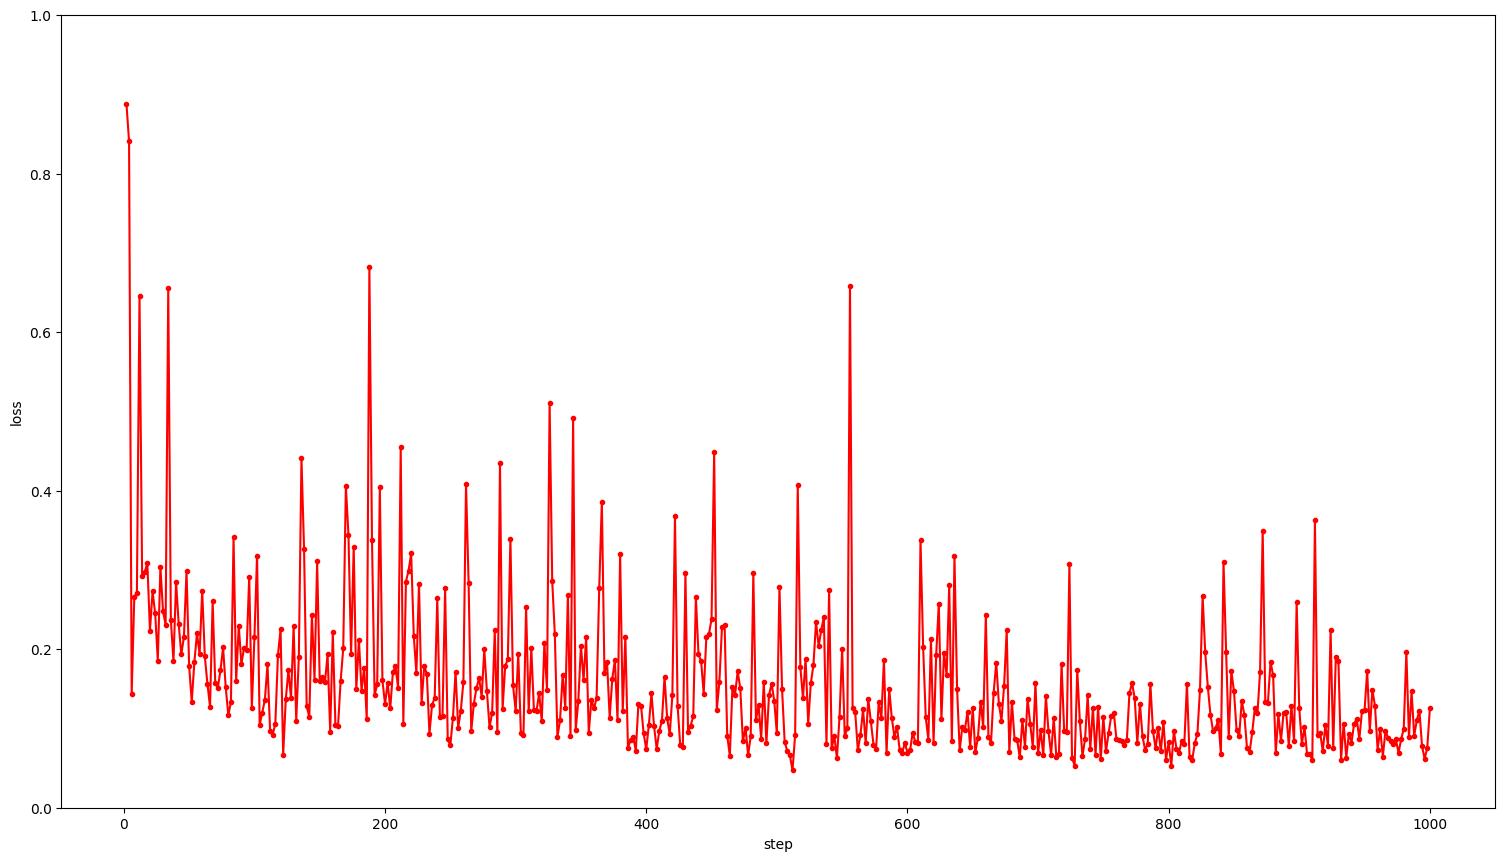

In [11]:
from torch.utils.data import DataLoader
from collections import defaultdict
import time
import argparse
from tqdm import tqdm
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
"""
def print_metrics(metrics, epoch_samples, phase='train'):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def calc_loss(pred,target,metrics,bce_weight=0.5) :
    #bce = F.binary_cross_entropy_with_logits(pred,target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred,target) 

    #loss = bce * bce_weight + dice * (1 - bce_weight)
    

    metrics['bce'] += 1#bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += 1#loss.data.cpu().numpy() * target.size(0)

    return metrics['loss']
"""
checkpoint_path = "checkpoint.pth"
data_path = '/content/drive/MyDrive/data/train/'
num_workers = 2
batch_size = 2
"""
#what does data loader do?
Dataset stores the samples and their corresponding labels, and 
DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

"""

def train_net(model,
              device,
              epochs: int =10,
              batch_size: int = 1,
              learning_rate: float = 0.001,
              #val_percent: float = 0.1,
              #save_checkpoint: bool = True,
             # img_scale: float = 0.5,
              amp: bool = False
):
#print("training the network...")
# Fetch images and labels.
  model.train()  #funciton of the module superclass ..sets the model to train.
  train_set = TrainDataset(data_path)
  training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
 # https://github.com/milesial/Pytorch-UNet/blob/master/train.py 

  optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
  criterion = nn.CrossEntropyLoss()
  if isinstance(criterion,torch.nn.Module): ##just to be sure that criterion is on the correct device.
    criterion.to(device)
  global_step = 0
  steps =[]
  losses=[]
  for epoch in range(epochs) :
    #torch.set_grad_enabled(True)
    epoch_samples = 0
    epoch_loss=0
    metrics = defaultdict(float)
    since = time.time()
  
    with tqdm(len(train_set), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:     
      for iteration, sample in enumerate(training_data_loader):
          img, mask = sample
          img=img.unsqueeze(0)
          img  = img.to(device = device)
          #https://discuss.pytorch.org/t/only-batches-of-spatial-targets-supported-non-empty-3d-tensors-but-got-targets-of-size-1-1-256-256/49134/18 
          mask = mask.squeeze(1)
          mask = mask.to(device,dtype = torch.long)

      
          #mask = F.one_hot(mask,4).permute(0,3,1,2).float()
          #print(mask.shape)
          """
          torch.cuda.amp and torch provide convenience methods for mixed precision,
          where some operations use the torch.float32 (float) datatype and other operations use torch.float16 (half).
          Some ops, like linear layers and convolutions, are much faster in float16. 
          Other ops, like reductions, often require the dynamic range of float32. 
          Mixed precision tries to match each op to its appropriate datatype.
          """
          #with torch.cuda.amp.autocast(enabled = amp)
          out  = model(img)
          #print(out.shape)
          loss = criterion (out,mask) # +dice_loss(F.softmax(out,dim=1).float(),
                                                  #mask,multiclass = True)
    
    # Then write your BACKWARD & OPTIMIZE below
    # Note: Compute Loss and Optimize
    #loss = criterion(out,mask)
    #loss_value = loss.item()
    #train_losses.append(loss_value)
    #loss.backward()
          optimizer.zero_grad(set_to_none=True)
          grad_scaler.scale(loss).backward()
          grad_scaler.step(optimizer)
          grad_scaler.update()

          pbar.update(img.shape[0])
          global_step += 1
          epoch_loss += loss.item()
          losses.append(loss.item())
          steps.append(global_step)

          #experiment.log({
           #         'train loss': loss.item(),
            #        'step': global_step,
             #       'epoch': epoch
               # })
          print('train loss',loss.item(),' step :',global_step,' epoch :',epoch)
          pbar.set_postfix(**{'loss (batch)': loss.item()})
  plt.plot(steps[1::2],losses[1::2],'.r-')
  plt.xlabel("step")
  plt.ylabel("loss")
  x1,x2,y1,y2 = plt.axis()  
  plt.axis((x1,x2,0,1))
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5, forward=True)
  fig.set_dpi(100)
  plt.show()
train_net(model,device)

    

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [ ]:
import numpy as np
from torch.autograd import Variable

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 4
batch_size = 2

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

for iteration, sample in enumerate(test_data_loader):
    img = sample
    print(img.shape)

    plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    plt.pause(1)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()